In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, ttest_rel

In [2]:
data = pd.read_csv('/project/deeprna/data/revision/eqtl/finemapped_eqtls_14tissue_corgi.tsv', sep='\t')
print(data.shape)
# Drop any row with na. any column.
data = data.dropna(how='any')
print(data.shape)
data.head()

(16507, 176)
(16395, 176)


,phenotype_id,gene_name,biotype,variant_id,pip,af,cs_id,cs_size,afc,afc_se,...,center_mid_cage_snp_furthest_64_mean_diff_other,center_mid_rampage_genebody_64_mean_diff_other,center_mid_rampage_snp_furthest_64_mean_diff_other,center_mid_rna_total_genebody_64_mean_diff_other,center_mid_rna_total_snp_furthest_64_mean_diff_other,center_mid_rna_polya_genebody_64_mean_diff_other,center_mid_rna_polya_snp_furthest_64_mean_diff_other,center_mid_rna_total_genebody_4_mean_diff_other,center_mid_h3k79me2_genebody_4_mean_diff_other,center_mid_rna_total_stranded_genebody_4_mean_diff_other
0,ENSG00000188976.11,NOC2L,protein_coding,chr1_966227_C_G_b38,0.999050,0.921456,1,1,-0.344005,0.134150,...,-0.000069,-0.000087,-0.000067,0.000978,0.000284,0.000451,0.000437,0.000182,-0.000348,0.000220
1,ENSG00000215915.10,ATAD3C,protein_coding,chr1_1456829_G_C_b38,0.999999,0.199234,1,1,1.811029,0.205054,...,-0.000156,0.000000,0.000000,-0.000093,-0.000118,-0.000088,-0.000105,-0.000140,-0.000054,-0.000140
2,ENSG00000189339.12,SLC35E2B,protein_coding,chr1_1665061_C_T_b38,0.951016,0.224138,1,1,-0.936484,0.076654,...,-0.000007,0.000163,0.000000,-0.000526,-0.000663,0.001083,0.001344,-0.000657,-0.005021,-0.001023
3,ENSG00000008128.23,CDK11A,protein_coding,chr1_1689221_G_A_b38,1.000000,0.040230,1,1,-2.186554,0.242038,...,0.000022,0.000021,-0.000038,-0.000018,-0.001062,-0.000669,-0.002797,0.000216,-0.001402,0.000213
4,ENSG00000008128.23,CDK11A,protein_coding,chr1_1689221_G_A_b38,1.000000,0.040230,1,1,-2.186554,0.242038,...,-0.000003,0.000000,-0.000089,-0.006120,-0.001795,-0.007292,-0.003086,-0.010417,0.000391,0.000000


In [3]:
n_unique_variants = len(set(data['variant_id']))
n_unique_genes = len(set(data['gene_name']))
n_associations = data.shape[0]
print(f'Number of unique variants: {n_unique_variants}')
print(f'Number of unique genes: {n_unique_genes}')
print(f'Number of variant-gene associations: {n_associations}')

Number of unique variants: 6487
Number of unique genes: 5121
Number of variant-gene associations: 16395


In [ ]:
readouts = [
    'center_snp_rna_total_genebody_4_mean_diff',
    'center_snp_h3k4me1_snp_furthest_64_mean_diff',
    'center_snp_h3k4me2_snp_furthest_64_mean_diff',
    'center_snp_h3k4me3_snp_furthest_64_mean_diff',
    'center_snp_h3k27ac_snp_furthest_64_mean_diff',
    'center_snp_h3k9ac_snp_furthest_64_mean_diff'
]
data_norm = data.copy()
for readout in readouts:
    min_val = data[readout].min()
    max_val = data[readout].max()
    data_norm[readout] = data[readout] / max(abs(min_val), abs(max_val))
    # Also normalize the other tissue feature
    min_val_other = data[readout + '_other'].min()
    max_val_other = data[readout + '_other'].max()
    data_norm[readout + '_other'] = data[readout + '_other'] / max(abs(min_val_other), abs(max_val_other))

data['ensemble'] = data_norm[readouts].mean(axis=1)
data['ensemble_other'] = data_norm[[f + '_other' for f in readouts]].mean(axis=1)
readouts.append('ensemble')

In [6]:
# Check avg. performance by abs distance to tss
data['distance_bin'] = pd.cut(np.abs(data.tss_distance), bins=[0, 1000, 10_000, 40_000, 200_000], labels=['0-1kb', '1-10kb', '10-40kb', '40-196kb'])
distance_results = []

for tissue in data['tissue'].unique():
    subset = data[data['tissue'] == tissue]
    for readout in readouts:
        for dist_bin in ['0-1kb', '1-10kb', '10-40kb', '40-196kb']:
            bin_subset = subset[subset['distance_bin'] == dist_bin]
            x = bin_subset[readout]
            y = bin_subset['afc']
            corr, pval = pearsonr(x, y)
            s_corr, s_pval = spearmanr(x, y)

            # Sign concordance
            sign_concordant = np.sum(np.sign(x) == np.sign(y))
            total = len(x)
            concordance_rate = sign_concordant / total * 100

            # Other tissue
            x_other = bin_subset[readout + '_other']
            sign_concordant_other = np.sum(np.sign(x_other) == np.sign(y))
            concordance_rate_other = sign_concordant_other / total * 100
            s_corr_other, s_pval_other = spearmanr(x_other, y)

            distance_results.append({
                'tissue': tissue,
                'readout': readout,
                'distance_bin': dist_bin,
                'pearson_r': corr,
                'p_value': pval,
                'spearman_r': s_corr,
                'spearman_p': s_pval,
                'sign_conc': concordance_rate,
                'N': len(x),
                'sign_conc_other': concordance_rate_other,
                'spearman_r_other': s_corr_other,
                'spearman_p_other': s_pval_other,
            })

distance_results_df = pd.DataFrame(distance_results)
distance_results_df.head()

,tissue,readout,distance_bin,pearson_r,p_value,spearman_r,spearman_p,sign_conc,N,sign_conc_other,spearman_r_other,spearman_p_other
0,Liver,center_snp_rna_total_genebody_4_mean_diff,0-1kb,0.283725,0.008504,0.391393,0.000212,68.235294,85,69.411765,0.383945,0.000286
1,Liver,center_snp_rna_total_genebody_4_mean_diff,1-10kb,0.136124,0.115429,0.205945,0.016559,60.740741,135,50.370370,0.168899,0.050197
2,Liver,center_snp_rna_total_genebody_4_mean_diff,10-40kb,0.135130,0.128307,0.181912,0.039871,56.250000,128,56.250000,0.145349,0.101628
3,Liver,center_snp_rna_total_genebody_4_mean_diff,40-196kb,0.158735,0.100830,-0.103834,0.284886,47.222222,108,53.703704,0.117623,0.225372
4,Liver,center_snp_h3k4me1_snp_furthest_64_mean_diff,0-1kb,0.250860,0.020573,0.325790,0.002345,70.588235,85,60.000000,0.257175,0.017500


In [7]:
bins_order = ['0-1kb', '1-10kb', '10-40kb', '40-196kb']
distance_results_df['distance_bin'] = pd.Categorical(distance_results_df['distance_bin'], categories=bins_order, ordered=True)

In [64]:
training_tissues = ['Colon_Transverse', 'Nerve_Tibial', 'Lung', 'Artery_Aorta',
    'Pancreas', 'Brain_Cortex', 'Thyroid', 'Heart_Left_Ventricle',
    'Adipose_Subcutaneous']

test_tissues = ['Liver', 'Skin_Not_Sun_Exposed_Suprapubic',
    'Skin_Sun_Exposed_Lower_leg', 'Prostate', 'Testis']

tissue_names_map = {
    'Skin_Not_Sun_Exposed_Suprapubic': 'Skin (Not Sun Exposed)',
    'Skin_Sun_Exposed_Lower_leg': 'Skin (Sun Exposed)',
    'Colon_Transverse': 'Colon',
    'Nerve_Tibial': 'Nerve',
    'Artery_Aorta': 'Artery',
    'Brain_Cortex': 'Brain',
    'Heart_Left_Ventricle': 'Heart',
    'Adipose_Subcutaneous': 'Adipose',
    'Liver': 'Liver',
    'Prostate': 'Prostate',
    'Testis': 'Testis',
    'Lung': 'Lung',
    'Pancreas': 'Pancreas',
    'Thyroid': 'Thyroid',
    'Average': 'Average'
}

readout_names_map = {
    'center_snp_rna_total_genebody_4_mean_diff': 'RNA',
    'center_snp_h3k4me1_snp_furthest_64_mean_diff': 'H3K4me1',
    'center_snp_h3k4me2_snp_furthest_64_mean_diff': 'H3K4me2',
    'center_snp_h3k4me3_snp_furthest_64_mean_diff': 'H3K4me3',
    'center_snp_h3k27ac_snp_furthest_64_mean_diff': 'H3K27ac',
    'center_snp_h3k9ac_snp_furthest_64_mean_diff': 'H3K9ac',
    'ensemble': 'Ensemble'
}

## Fig. 7b

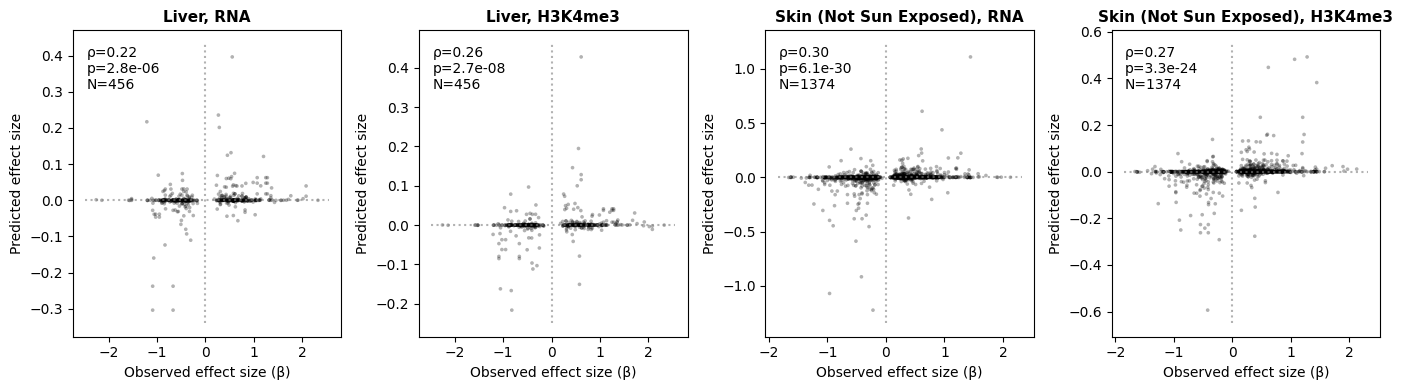

In [43]:
selected = [
    ('Liver', 'center_snp_rna_total_genebody_4_mean_diff'),
    ('Liver', 'center_snp_h3k4me3_snp_furthest_64_mean_diff'),
    ('Skin_Not_Sun_Exposed_Suprapubic', 'center_snp_rna_total_genebody_4_mean_diff'),
    ('Skin_Not_Sun_Exposed_Suprapubic', 'center_snp_h3k4me3_snp_furthest_64_mean_diff')
]

# Figure with 1 row, 4 columns, scatterplot for each selected tissue-readout pair, with rho, p, N
fig, axes = plt.subplots(1, 4, figsize=(14,4))
for ax, (tissue, readout) in zip(axes, selected):
    subset = data[data['tissue'] == tissue]
    rho, p = spearmanr(subset[readout], subset['slope'])
    N = subset.shape[0]

    sns.scatterplot(data=subset, x='slope', y=readout, alpha=0.3, s=7, color='black', edgecolor='none', ax=ax)
    ax.text(0.05, 0.95, f'ρ={rho:.2f}\np={p:.1e}\nN={N}', transform=ax.transAxes,
            verticalalignment='top', fontsize=10)
    ax.vlines(0, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='grey', linestyles='dotted', alpha=0.6)
    ax.hlines(0, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], colors='grey', linestyles='dotted', alpha=0.6)
    ax.set_title(f'{tissue_names_map[tissue]}, {readout_names_map[readout]}', fontsize=11, weight='bold')
    ax.set_ylabel(f'Predicted effect size')
    ax.set_xlabel('Observed effect size (β)')

plt.tight_layout()
plt.savefig('/project/deeprna/figures/revision/fig7b.pdf', dpi=300)

## Fig. 7c

/scratch/local/ipykernel_83930/2690649352.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_data = subset.groupby('distance_bin')['spearman_r'].mean().reset_index()
/scratch/local/ipykernel_83930/2690649352.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_data = subset.groupby('distance_bin')['spearman_r'].mean().reset_index()
/scratch/local/ipykernel_83930/2690649352.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence t

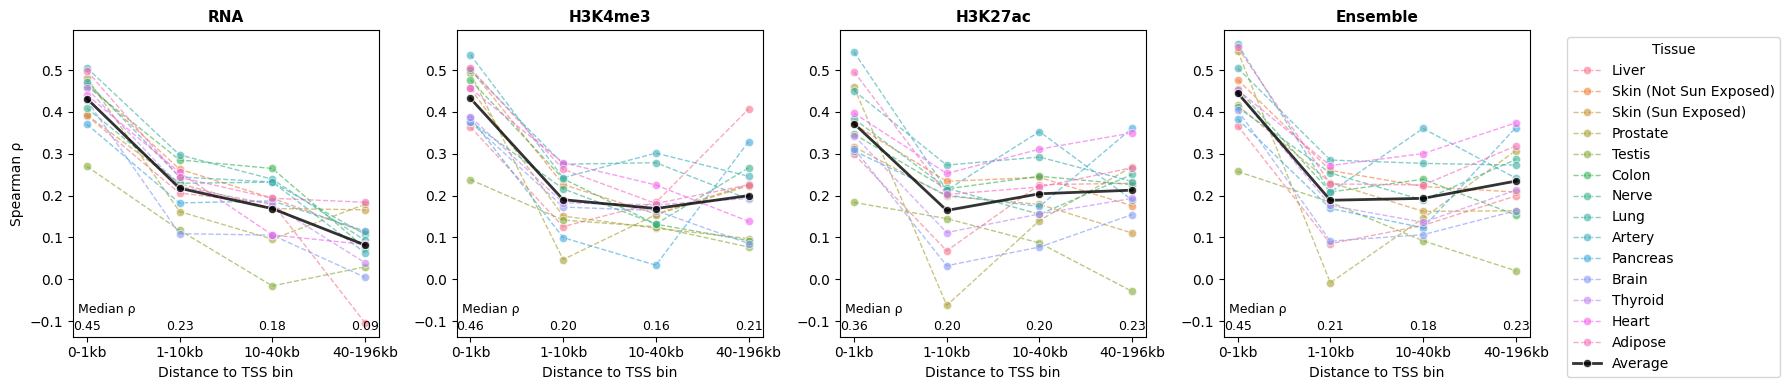

In [ ]:
# 1 row, 4 columns. rho plot stratified by distance, for 3 readouts
sel_readouts = ['center_snp_rna_total_genebody_4_mean_diff',
                'center_snp_h3k4me3_snp_furthest_64_mean_diff',
                 'center_snp_h3k27ac_snp_furthest_64_mean_diff',
                'ensemble']

fig, axes = plt.subplots(1, len(sel_readouts), figsize=(4.5*len(sel_readouts),4), sharey=True)
for i, readout in enumerate(sel_readouts):
    subset = distance_results_df[distance_results_df['readout'] == readout]
    sns.lineplot(data=subset, x='distance_bin', y='spearman_r', hue='tissue', marker='o', ax=axes[i], linestyle='--', linewidth=1, alpha=0.6)
    avg_data = subset.groupby('distance_bin')['spearman_r'].mean().reset_index()
    sns.lineplot(data=avg_data, x='distance_bin', y='spearman_r', color='black', marker='o', ax=axes[i], linewidth=2, label='Average', alpha=0.8)
    axes[i].set_title(f'{readout_names_map[readout]}', fontsize=11, weight='bold')
    axes[i].set_xlabel('Distance to TSS bin')

    # In each distance bin's center at the top of the plot, write median rho
    for dist_bin in bins_order:
        bin_data = subset[subset['distance_bin'] == dist_bin]
        median_rho = bin_data['spearman_r'].median()
        x_pos = bins_order.index(dist_bin)
        y_pos = -0.12
        axes[i].text(x_pos, y_pos, f'{median_rho:.2f}', horizontalalignment='center', fontsize=9, color='black')

    axes[i].text(bins_order[0], -0.08, '          Median ρ', horizontalalignment='center', fontsize=9, color='black')
    axes[i].tick_params(labelleft=True)

    if i == 0:
        axes[i].set_ylabel('Spearman ρ')
    if i != len(sel_readouts) -1:
        axes[i].legend().remove()
    else:
        handles, labels = axes[i].get_legend_handles_labels()
        new_labels = [tissue_names_map.get(l, l) for l in labels]
        axes[i].legend(handles, new_labels, bbox_to_anchor=(1.1, 1), loc='upper left', title='Tissue')

plt.tight_layout()
plt.savefig('/project/deeprna/figures/revision/fig7c.pdf', dpi=300)

## Fig. 7d

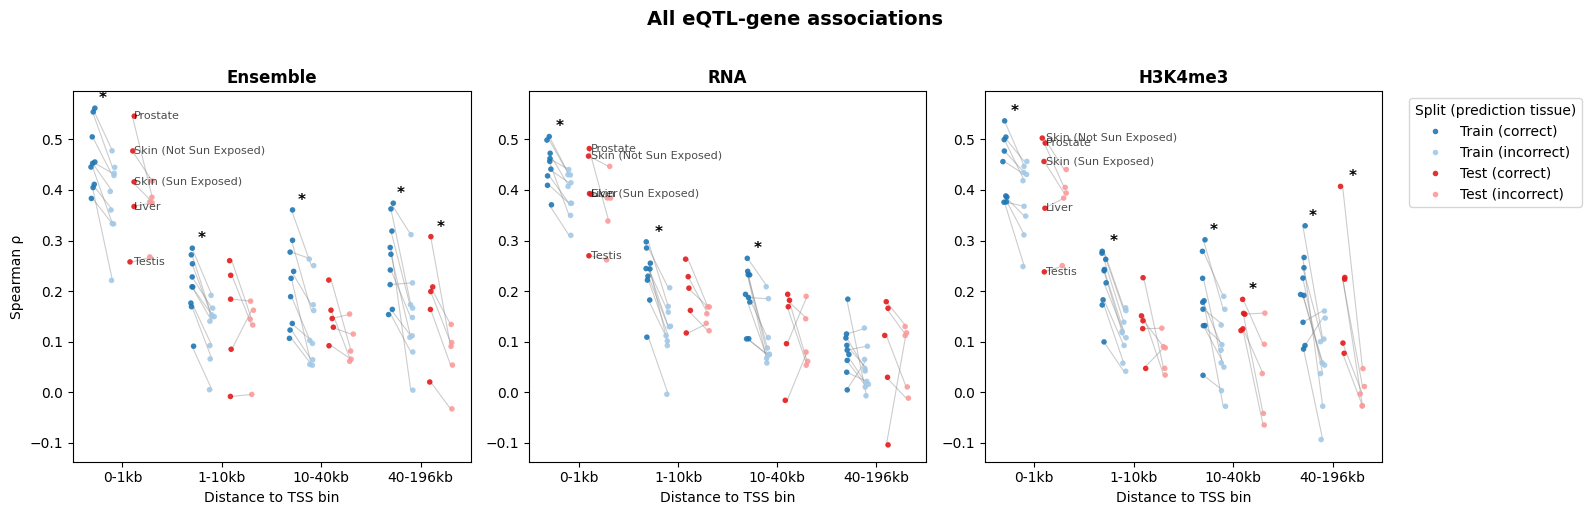

In [147]:
from scipy.stats import ttest_rel

# Define colors that pop: Darker for Correct, Lighter for Incorrect
pop_colors = {
    'Train (correct)': '#1f77b4', 'Train (incorrect)': '#a3c9e7', # Deep Blue & Sky Blue
    'Test (correct)': '#e31a1c', 'Test (incorrect)': '#fb9a99'    # Bright Red & Light Pink
}

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

for i, readout in enumerate(['ensemble', 'center_snp_rna_total_genebody_4_mean_diff', 'center_snp_h3k4me3_snp_furthest_64_mean_diff']):
    subset = distance_results_df[distance_results_df['readout'] == readout].copy()
    
    # Prep data
    plot_data = subset.melt(id_vars=['distance_bin', 'tissue_type', 'tissue'], 
                            value_vars=['spearman_r', 'spearman_r_other'], 
                            var_name='type', value_name='val')
    plot_data['group'] = plot_data.apply(lambda r: f"{r['tissue_type']} ({'correct' if r['type'] == 'spearman_r' else 'incorrect'})", axis=1)
    
    box_order = ['Train (correct)', 'Train (incorrect)', 'Test (correct)', 'Test (incorrect)']
    plot_data['group'] = pd.Categorical(plot_data['group'], categories=box_order, ordered=True)

    # 1. Stripplot with dodge (standard Seaborn dodge with 4 categories uses these offsets)
    sns.stripplot(data=plot_data, x='distance_bin', y='val', hue='group', 
                  order=bins_order, hue_order=box_order, dodge=True, 
                  palette=pop_colors, ax=axes[i], size=4, alpha=0.9, jitter=0.1)

    # 2. Manual Lines and Stats
    # Standard offsets for dodge=True with 4 hues are: -0.3, -0.1, 0.1, 0.3
    offsets = {'Train (correct)': -0.3, 'Train (incorrect)': -0.1, 
               'Test (correct)': 0.1, 'Test (incorrect)': 0.3}

    for j, dist_bin in enumerate(bins_order):
        bin_data = subset[subset['distance_bin'] == dist_bin]
        
        # Draw lines between paired dots
        for _, row in bin_data.iterrows():
            t_type = row['tissue_type']
            x_start = j + offsets[f'{t_type} (correct)']
            x_end = j + offsets[f'{t_type} (incorrect)']
            axes[i].plot([x_start, x_end], [row['spearman_r'], row['spearman_r_other']], 
                         color='gray', alpha=0.4, linewidth=0.8, zorder=0)

        # Asterisks for Significance
        for t_type, o1, o2 in [('Train', -0.3, -0.1), ('Test', 0.1, 0.3)]:
            group_data = bin_data[bin_data['tissue_type'] == t_type]
            if len(group_data) > 1:
                _, p = ttest_rel(group_data['spearman_r'], group_data['spearman_r_other'])
                if p < 0.05:
                    y_max = max(group_data[['spearman_r', 'spearman_r_other']].values.max(), 0)
                    axes[i].text(j + (o1 + o2)/2, y_max + 0.01, '*', 
                                 ha='center', color='black', fontsize=11, fontweight='bold')

    # For test tissues, label the tissues next to the points for only correct ones
    j = 0
    dist_bin = bins_order[0]
    bin_data = subset[subset['distance_bin'] == dist_bin]
    test_data = bin_data[bin_data['tissue_type'] == 'Test']
    for _, row in test_data.iterrows():
        x_pos = j + offsets['Test (correct)']
        y_pos = row['spearman_r']
        axes[i].text(x_pos + 0.02, y_pos, tissue_names_map.get(row['tissue'], row['tissue']),
                        fontsize=8, verticalalignment='center', color='black', alpha=0.7)
            
    # Formatting
    axes[i].set_title(readout_names_map.get(readout, readout), fontsize=12, weight='bold')
    axes[i].set_xlabel('Distance to TSS bin')
    axes[i].tick_params(labelleft=True) # Keep labels visible as requested
    
    if i == 0:
        axes[i].set_ylabel('Spearman ρ')
    
    # Legend handling (Mapping names and pairing colors correctly)
    if i == 2:
        handles, labels = axes[i].get_legend_handles_labels()
        axes[i].legend(handles, labels, title='Split (prediction tissue)', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        axes[i].get_legend().remove()

plt.suptitle('All eQTL-gene associations', fontsize=14, weight='bold', y=1.02)
plt.tight_layout()
plt.savefig('/project/deeprna/figures/revision/fig7d.pdf', dpi=300)